In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Exploratory data analysis

In [5]:
add = '' #write address

In [6]:
df = pd.read_csv(add, header=0)
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [5]:
df = pd.get_dummies(df)
df.age

0      18
1      17
2      15
3      15
4      16
       ..
390    20
391    17
392    21
393    18
394    19
Name: age, Length: 395, dtype: int64

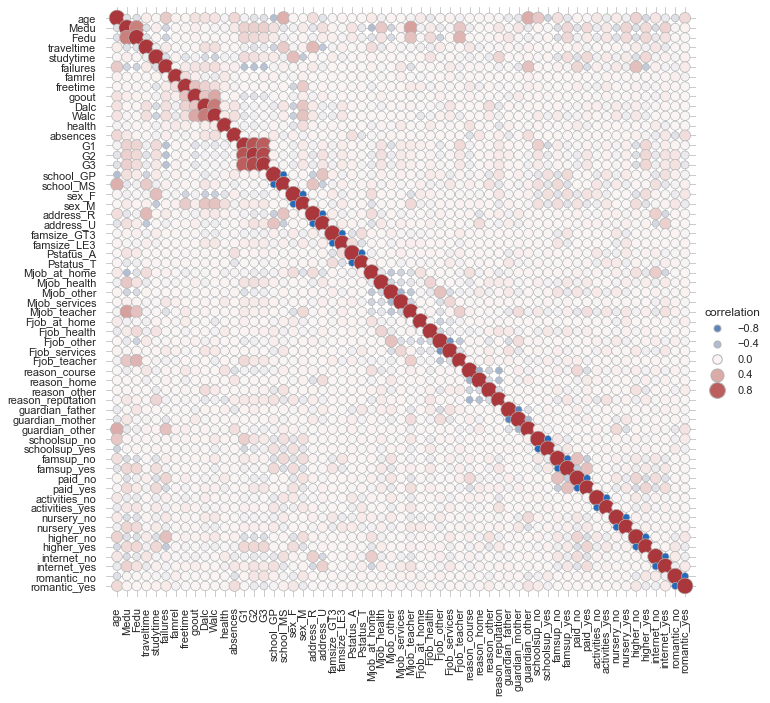

In [6]:
sns.set_theme(style="whitegrid")
used_columns = df.columns
df = df.loc[:, used_columns]
corr = df.corr().stack().reset_index(name="correlation")
g = sns.relplot(
    data=corr,
    x="level_0", y="level_1", hue="correlation", size="correlation",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-.2, .8),)
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)
for artist in g.legend.legendHandles:
    artist.set_edgecolor(".7")

<AxesSubplot:xlabel='G1', ylabel='G2'>

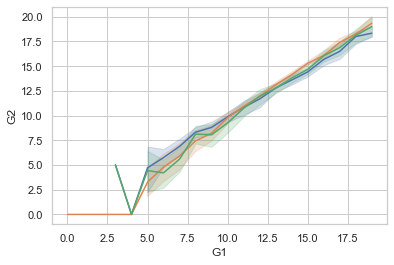

In [16]:
sns.lineplot( x='G1', y='G2', data=df)
sns.lineplot( x='G2', y='G3', data=df)
sns.lineplot( x='G1', y='G3', data=df)


Stable and high correlation between G1, G2 and G3.
It is reasonable to use only G3.

According to the correlation map, the following parameters affect G3:

In [ ]:
df_ex = df[['failures', 'studytime', 'Medu', 'Fedu', 'higher_yes', 'internet_yes', 
          'schoolsup_no', 'goout', 'G3']]

<AxesSubplot:xlabel='failures', ylabel='G3'>

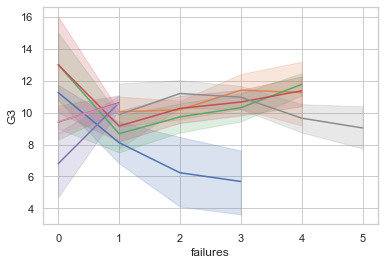

In [19]:
sns.lineplot( x='failures', y='G3', data=df)
sns.lineplot( x='studytime', y='G3', data=df)
sns.lineplot( x='Medu', y='G3', data=df)
sns.lineplot( x='Fedu', y='G3', data=df)
sns.lineplot( x='higher_yes', y='G3', data=df)
sns.lineplot( x='internet_yes', y='G3', data=df)
sns.lineplot( x='schoolsup_no', y='G3', data=df)
sns.lineplot( x='goout', y='G3', data=df)

It is necessary to determine the nature of the data and the type of distribution:

"\nMedu, Fedu - mother's/father's education (numeric: 0 - none, 1 - primary education (4th grade), \n                                                   2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)\nstudytime - weekly study time (numeric: 1 - 10 hours)\nfailures - number of past class failures (numeric: n if 1<=n<3, else 4)\nhigher - wants to take higher education (binary: yes or no)\ninternet - Internet access at home (binary: yes or no)\ngoout - going out with friends (numeric: from 1 - very low to 5 - very high)\nschoolsup - extra educational support (binary: yes or no)\nG3 - final grade (numeric: from 0 to 20, output target)\n"

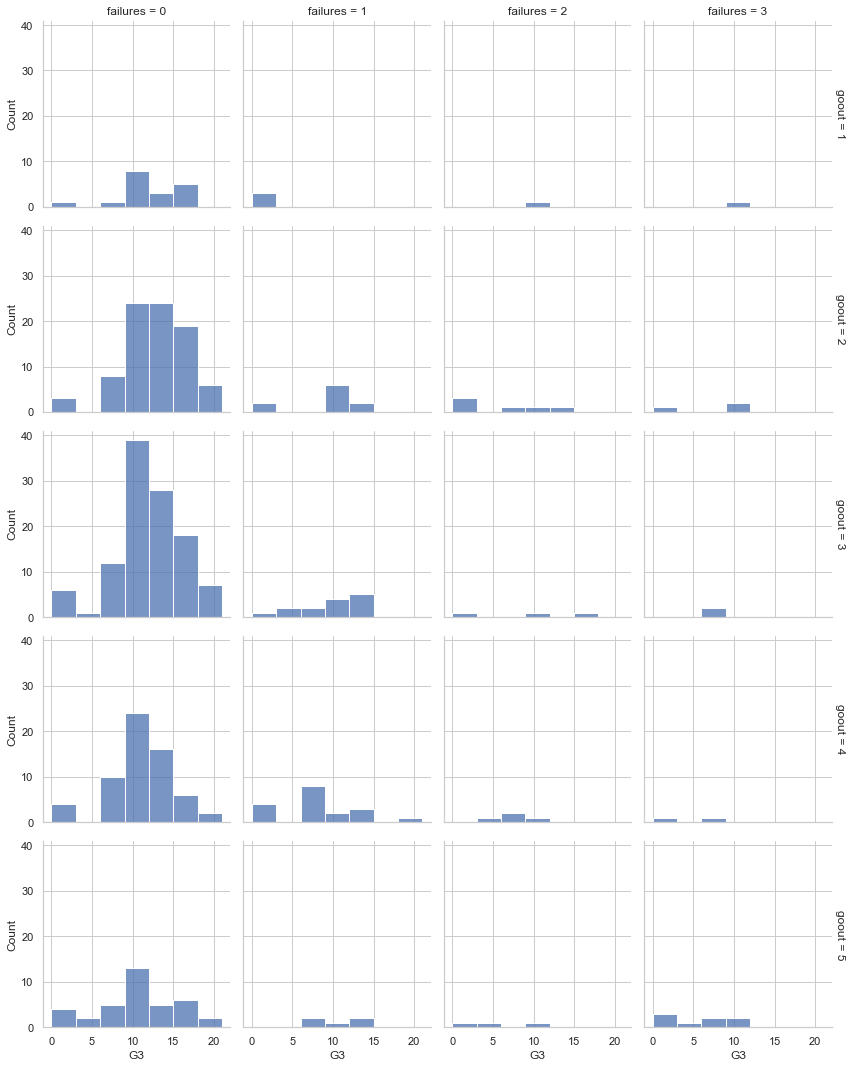

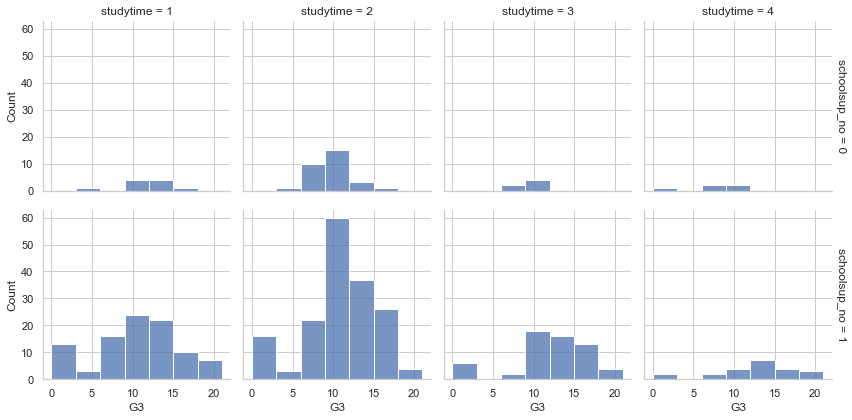

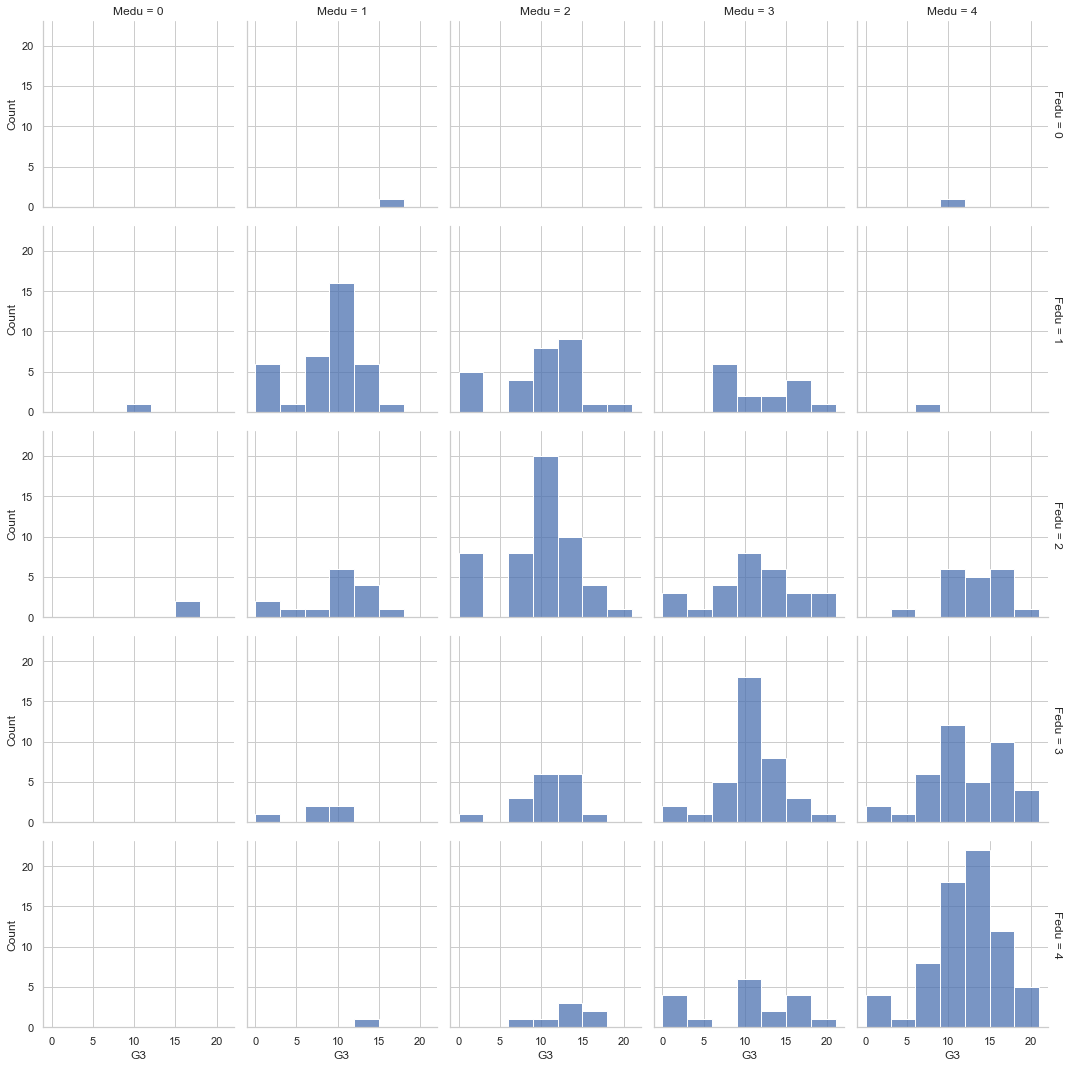

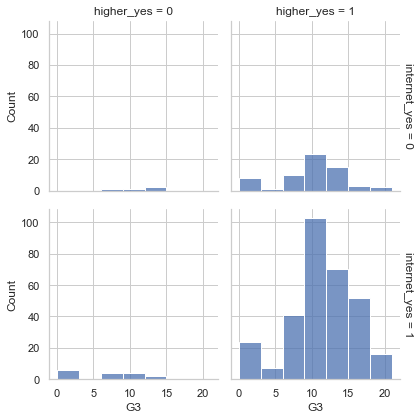

In [7]:
sns.displot(df_ex, x='G3', col='failures', row='goout', binwidth=3, height=3, facet_kws=dict(margin_titles=True),)
sns.displot(df_ex, x='G3', col='studytime', row='schoolsup_no', binwidth=3, height=3, facet_kws=dict(margin_titles=True),)
sns.displot(df_ex, x='G3', col='Medu', row='Fedu', binwidth=3, height=3, facet_kws=dict(margin_titles=True),)
sns.displot(df_ex, x='G3', col='higher_yes', row='internet_yes', binwidth=3, height=3, facet_kws=dict(margin_titles=True),)
'''
Medu, Fedu - mother's/father's education (numeric: 0 - none, 1 - primary education (4th grade), 
                                                   2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
studytime - weekly study time (numeric: 1 - 10 hours)
failures - number of past class failures (numeric: n if 1<=n<3, else 4)
higher - wants to take higher education (binary: yes or no)
internet - Internet access at home (binary: yes or no)
goout - going out with friends (numeric: from 1 - very low to 5 - very high)
schoolsup - extra educational support (binary: yes or no)
G3 - final grade (numeric: from 0 to 20, output target)
'''

All data selections have approximate Gauss distribution.
The largest number of ratings has obtained when the following conditions were met:
*failures=0 and goout=3
*studytime=2 and schoolsup_no=1
*Medu=4 and Fedu=4
*higher_yes=1 and internet_yse=1
This means that the majority of students have no fails with class, 2 hours of study, walk average time, haven't education support, their parents have higher education and they have internat and want to get higher.
Moreover, significant bias towards a higher score is present precisely in families with parents with the higher edu.

Of interest is the relationship between (Medu, Fedu) and G3:

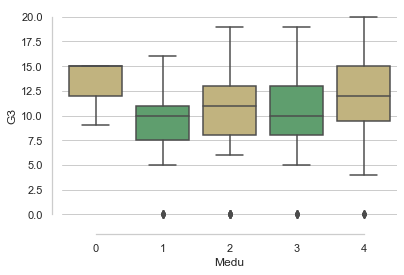

In [8]:
sns.boxplot(x='Medu', y='G3',  palette=['y', 'g'], data=df_ex)
sns.despine(offset=10, trim=True)

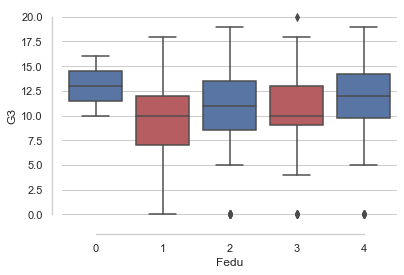

In [9]:
sns.boxplot(x='Fedu', y='G3',  palette=['b', 'r'], data=df_ex)
sns.despine(offset=10, trim=True)

In [10]:
df_ex[['G3']].mean()

G3    10.41519
dtype: float64

Relatively average across all the dataset, there is a strong relationship between parental education and student average grade.
In Medu and Fedu 0 there are the emissions.

# A little model on xgb

In [50]:
x = df.drop(columns=['G3'])
y = df[['G3']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
xgb = XGBClassifier(eta=0.2, max_depth=6, gamma=0, alpha=0.1)

In [51]:
xgb.fit(x_train, y_train)
y_pred = [round(y_) for y_ in xgb.predict(x_test)]
print(accuracy_score(y_test, y_pred))

0.4810126582278481
